In [1]:
import numpy as np
from numpy import sin, cos, exp, pi, log, sqrt
import matplotlib.pyplot as plt
import emcee
import corner

In [4]:
def gelman_rubin(chains):
    """
    chains: array of shape (nsteps, nchains, ndim)
    """
    nsteps, nchains, ndim = chains.shape
    r_hat = np.zeros(ndim)
    
    for d in range(ndim):
        chain_means = np.mean(chains[:, :, d], axis=0)
        overall_mean = np.mean(chain_means)
        
        # Between-chain variance
        B = nsteps * np.var(chain_means, ddof=1)
        
        # Within-chain variance
        W = np.mean(np.var(chains[:, :, d], axis=0, ddof=1))
        
        # Estimate of marginal posterior variance
        var_hat = (1 - 1/nsteps) * W + B/nsteps
        
        r_hat[d] = np.sqrt(var_hat / W)
    
    return r_hat

In [2]:
mu0 = 1e25 #GUT scale
vH = 250*1e9
betak = 35/6
moves = [
    emcee.moves.StretchMove(a=1.5),
    emcee.moves.DEMove(),             # differential evolution
]

#Normal hierarchy values
obs_msq21 = 7.5*1e-5
obs_msq31 = 2.55*1e-3
obs_s12sq = 3.18*1e-1
obs_s23sq = 5.74*1e-1
obs_s13sq = 2.2*1e-2
#obs_CP = 1.08*pi

sigma_msq21 = 0.21*1e-5
sigma_msq31 = 0.025*1e-3
sigma_s12sq = 0.16*1e-1
sigma_s23sq = 0.14*1e-1
sigma_s13sq = 0.065*1e-2
#sigma_CP = 0.125*pi

#CL Yukawa coefficients
ye = 0.51099895000*1e6*sqrt(2)/(250*1e9)
ymu = 105.6583755*1e6*sqrt(2)/(250*1e9)
ytau = 1776.93*1e6*sqrt(2)/(250*1e9)

#1-loop beta function solution
def g(g0, k, v):
    return (g0**(-2) + (k/(8*pi**2))*log(v/mu0))**(-1/2)

#Mass
def Mnu(k, g0, ve, vmu, vtau):
    ge = g(g0, k, ve)
    gmu = g(g0, k, vmu)
    gtau = g(g0, k, vtau)
    return np.array([[np.exp(-8*np.pi**2/(ge**2))*ye, 0, 0],
                     [0, np.exp(-8*np.pi**2/(gmu**2))*ymu, 0],
                     [0,0,np.exp(-8*np.pi**2/(gtau**2))*ytau]])

#Mixing
def Inu(k, g0, ve, vmu, vtau):
    ge = g(g0, k, ve)
    gmu = g(g0, k, vmu)
    gtau = g(g0, k, vtau)
    inste = np.exp(-8*np.pi**2/(ge**2))
    instmu = np.exp(-8*np.pi**2/(gmu**2))
    insttau = np.exp(-8*np.pi**2/(gtau**2))
    remu = ve/vmu
    retau = ve/vtau
    rmutau = vmu/vtau
    return 0.01*np.array([[inste*ye, inste*ye/remu, inste*ye/retau],
                         [instmu*ymu*remu, instmu*ymu, instmu*ymu/rmutau],
                         [insttau*ytau*retau, insttau*ytau*rmutau, insttau*ytau]])

def log_prob(theta):
    g0 = theta[0]
    ve, vmu, vtau = 10**theta[1:]
    if (np.any(theta[1:] < 12)):
        return -np.inf
    if np.any(theta[1:] > 23):
        return -np.inf
    if np.any(g0**(-2) + (betak/(8*pi**2))*log(10**theta[1:]/mu0) <= 0):
        return -np.inf
    if g0 <= 0:
        return -np.inf
    if not (ve > vmu and vmu > vtau):
        return -np.inf

    Y = (vH/sqrt(2))*(Mnu(betak, g0, ve, vmu, vtau) + Inu(betak, g0, ve, vmu, vtau)) #Neutrino Yukawa after EWSB

    eigenvals, U = np.linalg.eig(Y)
    masses = np.abs(eigenvals)
    if np.sum(masses) > 0.2:
        return -np.inf

    dmsq21 = masses[1]**2 - masses[0]**2
    dmsq31 = masses[2]**2 - masses[0]**2

    s13sq = U[0,2]**2
    if s13sq <= 0 or s13sq >= 1:
        return -np.inf
    s12sq = (U[0,1]/sqrt(1-s13sq))**2
    s23sq = (U[1,2]/sqrt(1-s13sq))**2

    chi2 = ((dmsq21 - obs_msq21)/sigma_msq21)**2
    chi2 += ((dmsq31 - obs_msq31)/sigma_msq31)**2
    chi2 += ((s12sq - obs_s12sq)/sigma_s12sq)**2
    chi2 += ((s23sq - obs_s23sq)/sigma_s23sq)**2
    chi2 += ((s13sq - obs_s13sq)/sigma_s13sq)**2

    return -0.5*chi2

#v = np.logspace(13, 23, 1000)
#plt.plot(v, g(1, betak, v))
#plt.xscale('log')
#plt.show()    
    

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1466.49it/s]


R = 1.2456056410116987, 1.0447336793144366, 1.7419093948780666, 1.7416000768750741 after 20000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1463.56it/s]


R = 1.1002597120869526, 1.0195411945332686, 1.466264663596659, 1.4660237881428941 after 30000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1389.85it/s]


R = 1.0270604362038074, 1.0097803381901524, 1.2434130985075564, 1.2434077661299439 after 40000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1478.75it/s]


R = 1.0217932719724991, 1.0205989541169365, 1.1548990780757207, 1.1548178977226058 after 50000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.85it/s]


R = 1.0267903217791574, 1.0305599557909806, 1.1168141829171125, 1.1167382494305198 after 60000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1454.41it/s]


R = 1.031719575630813, 1.0405726998765767, 1.0921780178788014, 1.0921298467111382 after 70000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1489.49it/s]


R = 1.0459891842608677, 1.0571917348934428, 1.065734498072505, 1.0656895354316709 after 80000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1510.01it/s]


R = 1.0451840172333253, 1.0596389977081166, 1.0596096144363543, 1.0595448560316725 after 90000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1538.18it/s]


R = 1.0378167543120167, 1.057994529202174, 1.0601690380334725, 1.0601106162004788 after 100000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1460.50it/s]


R = 1.0331654305340312, 1.0574037359267774, 1.0592125912498145, 1.0591777547353467 after 110000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1491.19it/s]


R = 1.0363564056216712, 1.0592812540052794, 1.0607065741359805, 1.0606690214958314 after 120000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1464.51it/s]


R = 1.0392789976865844, 1.053175333499406, 1.0754201018970706, 1.0753939846182057 after 130000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1484.34it/s]


R = 1.0415966299914907, 1.048379551321852, 1.084821642671042, 1.0848490540958435 after 140000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1484.62it/s]


R = 1.0414413845768862, 1.051126486333994, 1.0783089942563961, 1.0783342714470598 after 150000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1455.30it/s]


R = 1.0440002501124734, 1.0517229869160065, 1.0794046316620927, 1.0794456681447349 after 160000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1526.70it/s]


R = 1.0507191302009666, 1.055857221298023, 1.077641043970244, 1.077676822985317 after 170000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1537.65it/s]


R = 1.0474345169347363, 1.0557397303847182, 1.072121291889083, 1.072171206225638 after 180000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1499.74it/s]


R = 1.052714961292595, 1.0588140050369186, 1.069038216709592, 1.0691145597436884 after 190000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1353.75it/s]


R = 1.0557277507864364, 1.0580892567229474, 1.0695407473644638, 1.0696295268741836 after 200000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1503.77it/s]


R = 1.0566906392015827, 1.0598238153972792, 1.064065866322789, 1.064147202591051 after 210000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1473.81it/s]


R = 1.059675323453468, 1.0612803515069702, 1.0606244573467767, 1.060679823042262 after 220000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1562.80it/s]


R = 1.0595816967790663, 1.065181000825559, 1.049506036908757, 1.0495457134079702 after 230000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1508.39it/s]


R = 1.0631658024953248, 1.0682568248917594, 1.0471621262300976, 1.0471886975307367 after 240000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1472.72it/s]


R = 1.061628035470706, 1.0661429761817953, 1.0478700477803833, 1.047875284737095 after 250000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1536.00it/s]


R = 1.0608493592125214, 1.064202459515125, 1.048991389913111, 1.0489788103348388 after 260000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1449.02it/s]


R = 1.0527873946367818, 1.0571712521615462, 1.0537700896721744, 1.0537579367544465 after 270000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1452.15it/s]


R = 1.0488549154575815, 1.054823942268722, 1.0552726490407978, 1.0552609915051332 after 280000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1359.20it/s]


R = 1.0475835764588461, 1.05518401807927, 1.0529123781193892, 1.0529035270290021 after 290000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.76it/s]


R = 1.0455341407242964, 1.0557456317232552, 1.0521351000196404, 1.0521259749127947 after 300000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.69it/s]


R = 1.0436429079263139, 1.0568405550207183, 1.0497231787695598, 1.0497188216099622 after 310000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1450.44it/s]


R = 1.0424096497191484, 1.0585643241519072, 1.0481033492774483, 1.0480899499047966 after 320000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1500.87it/s]


R = 1.038969983622788, 1.0577106587840406, 1.0475427344116899, 1.0475183247041784 after 330000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1503.40it/s]


R = 1.036225956355253, 1.0562329175443246, 1.0471461324977143, 1.0471215124847293 after 340000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.48it/s]


R = 1.0384553837729995, 1.0595331866419997, 1.044089572763874, 1.0440645269833855 after 350000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1459.39it/s]


R = 1.035814424287261, 1.0587839945842121, 1.0419983643258968, 1.0419675035864087 after 360000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1514.25it/s]


R = 1.036059584256746, 1.0593816591056202, 1.0419391381726861, 1.041904379978299 after 370000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1483.39it/s]


R = 1.0369136371770091, 1.0601852548783637, 1.040912514640721, 1.0408761277765464 after 380000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1476.20it/s]


R = 1.0391341261226623, 1.0619940313103557, 1.0389816985983094, 1.038954931920036 after 390000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1504.71it/s]


R = 1.0392242122811077, 1.0622266320979246, 1.0368543959333236, 1.0368268225401558 after 400000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1505.90it/s]


R = 1.040604855702645, 1.0623882075861006, 1.0372828767399296, 1.0372582971338615 after 410000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1460.52it/s]


R = 1.0385699799511472, 1.0593671175566184, 1.039902829564912, 1.0398800567711814 after 420000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1477.83it/s]


R = 1.0396477873986814, 1.0593181391884892, 1.040911071749983, 1.0408879458807283 after 430000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1445.70it/s]


R = 1.041109265149196, 1.0594959954105785, 1.0415169443406553, 1.0414894712629186 after 440000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1449.13it/s]


R = 1.0422776902698534, 1.0592338425020402, 1.0424677640445337, 1.0424430055235991 after 450000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1537.83it/s]


R = 1.0430348641540295, 1.0605440668870316, 1.0401712593832662, 1.0401555445768116 after 460000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1415.26it/s]


R = 1.0446118150422052, 1.0629829390693473, 1.0374763887332488, 1.037463385705644 after 470000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1389.22it/s]


R = 1.0446895979182962, 1.0618217300128534, 1.0388427090699066, 1.0388243814257954 after 480000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1347.86it/s]


R = 1.0470311422713567, 1.0630007384648499, 1.0386921654357837, 1.0386725824120837 after 490000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1360.18it/s]


R = 1.0481225367731601, 1.0625076833141531, 1.0395040707374215, 1.0394872579408325 after 500000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1308.26it/s]


R = 1.0486623085201665, 1.0619977847816844, 1.0398369144774449, 1.0398211788243266 after 510000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1400.10it/s]


R = 1.0507894152890385, 1.0628272794892384, 1.039679618064313, 1.039669341875713 after 520000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1495.64it/s]


R = 1.0519679175250587, 1.0625380690072712, 1.040276473241854, 1.0402779814698784 after 530000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1461.89it/s]


R = 1.0520847080471682, 1.0596018653175934, 1.0418307595842295, 1.041835668899325 after 540000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1367.78it/s]


R = 1.0519909456150471, 1.0566183366416344, 1.0435608166747128, 1.043564247438355 after 550000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1552.15it/s]


R = 1.0551094465182416, 1.0585482155904595, 1.042564916695762, 1.0425771807978654 after 560000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1507.27it/s]


R = 1.054230836135661, 1.0582034745171673, 1.0411198781806623, 1.0411291270632244 after 570000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1558.72it/s]


R = 1.0537647460476935, 1.0582799340851148, 1.0401304964981843, 1.0401370619093635 after 580000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1402.08it/s]


R = 1.054318803653423, 1.058505406442402, 1.0390227410724395, 1.0390314607097462 after 590000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1464.16it/s]


R = 1.0560126874259705, 1.0590776050761284, 1.03776135818139, 1.0377700576004603 after 600000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1395.16it/s]


R = 1.0563448904076138, 1.058668445762844, 1.0371939602732085, 1.0372001818091274 after 610000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1461.77it/s]


R = 1.0550620721599084, 1.057342849121669, 1.036365665918727, 1.0363731995092105 after 620000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1503.25it/s]


R = 1.0545153556462685, 1.0581867411945098, 1.0345650358058907, 1.034569329588665 after 630000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1510.84it/s]


R = 1.0520991509135162, 1.0584564781307448, 1.0331496117301742, 1.0331458681451733 after 640000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1517.68it/s]


R = 1.0507194603658754, 1.0592291463363515, 1.0322392003866319, 1.0322357905184694 after 650000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1509.86it/s]


R = 1.04954163082445, 1.058872354560254, 1.0325639333323415, 1.0325578887051508 after 660000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1354.37it/s]


R = 1.0504336509145968, 1.0598768879917595, 1.0316083283138633, 1.0316024973930977 after 670000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1407.91it/s]


R = 1.049140903973267, 1.0588622055073584, 1.0319701174759526, 1.0319638759937666 after 680000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1304.50it/s]


R = 1.0476221116873645, 1.0580128054069384, 1.0324474217657147, 1.0324421924709328 after 690000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1468.71it/s]


R = 1.0487170268723058, 1.0583599810569009, 1.032543114976347, 1.0325350102697484 after 700000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1501.89it/s]


R = 1.0485827925160804, 1.057414775565793, 1.0336311449052782, 1.0336254552786683 after 710000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1473.05it/s]


R = 1.0500867510840348, 1.0578292985900757, 1.0338688775935276, 1.0338645361300014 after 720000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1515.83it/s]


R = 1.0507463808646635, 1.0571102602068239, 1.03439006379454, 1.0343817517591611 after 730000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1428.61it/s]


R = 1.0513498198034228, 1.0566440640729675, 1.0338697567939765, 1.033860653897811 after 740000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1472.98it/s]


R = 1.0538813167267522, 1.0578416643463446, 1.0332210445731704, 1.0332128146384556 after 750000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1445.32it/s]


R = 1.0555900487161627, 1.057415300730581, 1.0339921487966164, 1.0339847382691714 after 760000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1533.54it/s]


R = 1.0567782340344423, 1.0564546418390728, 1.0341100756729007, 1.0341025277772369 after 770000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1381.18it/s]


R = 1.059689443555847, 1.0568013403835557, 1.0340866131481001, 1.0340778260010188 after 780000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1436.61it/s]


R = 1.0628939216801725, 1.0566730616504738, 1.0343424841983178, 1.0343321887741828 after 790000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1517.29it/s]


R = 1.0655355717288868, 1.0554034558802148, 1.035501048239567, 1.0354923961281592 after 800000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1489.70it/s]


R = 1.068598526442444, 1.0550592811199355, 1.0358741424912696, 1.0358653857779032 after 810000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1518.68it/s]


R = 1.0709441123854624, 1.053463070864807, 1.0370564035074785, 1.0370482426844088 after 820000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1519.97it/s]


R = 1.074311678315753, 1.053827817972667, 1.0368711649899516, 1.036869101835414 after 830000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1523.27it/s]


R = 1.0781946974721057, 1.055293078639065, 1.0363171122856625, 1.0363214711790099 after 840000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1535.41it/s]


R = 1.081022227225608, 1.0554162614082827, 1.0365437073260397, 1.0365502179297297 after 850000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1482.34it/s]


R = 1.0844596758579033, 1.0570825464180058, 1.0356856776974024, 1.035691809730398 after 860000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1525.50it/s]


R = 1.0864399155330782, 1.0569064592834454, 1.036265432500697, 1.036274300490149 after 870000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1543.04it/s]


R = 1.087994117183181, 1.056781685588055, 1.036531113676026, 1.0365419642909275 after 880000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1505.45it/s]


R = 1.09076084207481, 1.0577146471551655, 1.0364795268878584, 1.0364883517016876 after 890000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1510.23it/s]


R = 1.0932435502102256, 1.0584997899278201, 1.036752071966693, 1.0367635874430863 after 900000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1452.64it/s]


R = 1.0945704171263626, 1.0588526426946774, 1.0363331209580922, 1.036343454507427 after 910000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1453.06it/s]


R = 1.0966585727592417, 1.0599961256731325, 1.0356023004716155, 1.0356130237552548 after 920000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1520.63it/s]


R = 1.09815791325353, 1.0607671316195795, 1.03488015334642, 1.0348908023018526 after 930000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1483.92it/s]


R = 1.0979864948640519, 1.0605860756194496, 1.0346107618887443, 1.0346195890910055 after 940000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1522.23it/s]


R = 1.096759739652053, 1.0607954105954402, 1.0344928109869962, 1.0345004111507532 after 950000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1516.97it/s]


R = 1.0941483231543871, 1.0600897249008092, 1.0342682880478473, 1.0342766440189468 after 960000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1286.62it/s]


R = 1.0920137174192566, 1.0596944794995684, 1.0341696793624533, 1.034173959567376 after 970000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1342.35it/s]


R = 1.090363275586675, 1.0588392499271198, 1.0346400840620695, 1.0346443296042858 after 980000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1525.15it/s]


R = 1.089172265045528, 1.058617823469429, 1.0344025976832822, 1.0344063238087695 after 990000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1523.51it/s]


R = 1.0873745882362018, 1.0579465913143093, 1.0337048560096922, 1.0337086952182282 after 1000000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1453.09it/s]


R = 1.0873636157999313, 1.0584054557335, 1.0336247210976017, 1.033629279412506 after 1010000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1524.63it/s]


R = 1.0865508789736906, 1.0585109120666534, 1.0338934590139408, 1.0338989349893801 after 1020000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1550.95it/s]


R = 1.0856257266451976, 1.058316674713435, 1.0338364559529198, 1.0338408095767286 after 1030000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1522.75it/s]


R = 1.0860521266278615, 1.0586596652276388, 1.0338251549632747, 1.0338301683697364 after 1040000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1532.82it/s]


R = 1.0871384422547858, 1.0597263805842054, 1.032711592847608, 1.0327181364088207 after 1050000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1443.79it/s]


R = 1.0872493928816898, 1.060314761242711, 1.0318977276761174, 1.0319033979107088 after 1060000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1569.97it/s]


R = 1.0875124578726654, 1.0613319048953165, 1.0314121254433928, 1.0314215032710468 after 1070000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1414.52it/s]


R = 1.0877827696326816, 1.0624703070745176, 1.031040228131996, 1.0310538550964703 after 1080000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1470.74it/s]


R = 1.0859850145851333, 1.0615565818319856, 1.031377311678942, 1.0313899467724326 after 1090000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1482.81it/s]


R = 1.0845547300376877, 1.0607192465272453, 1.0316328601280924, 1.031645963052515 after 1100000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1505.51it/s]


R = 1.0847313466876967, 1.060661058959959, 1.0317151112888665, 1.03173001299294 after 1110000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1490.27it/s]


R = 1.0849369698750742, 1.060601543376948, 1.0316809622405763, 1.0316985571826538 after 1120000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1343.83it/s]


R = 1.084272312691871, 1.0599059074305435, 1.0319936717054814, 1.0320104766334255 after 1130000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1493.23it/s]


R = 1.0838154279247314, 1.059535597308344, 1.032050643923078, 1.0320665677504088 after 1140000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1482.35it/s]


R = 1.0833811330701153, 1.0586545835034815, 1.0318836172003767, 1.031900422263257 after 1150000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1484.26it/s]


R = 1.0835099869113107, 1.0585238828439965, 1.0317286243639436, 1.0317475935998566 after 1160000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1466.92it/s]


R = 1.0840756450494702, 1.0585889728706441, 1.0316727251969966, 1.0316934134226572 after 1170000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1493.24it/s]


R = 1.0836409760453747, 1.0575623982978093, 1.03199757309808, 1.0320187273229646 after 1180000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1471.80it/s]


R = 1.084128447463645, 1.057892739800211, 1.0316921764325109, 1.0317132519750756 after 1190000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1498.63it/s]


R = 1.0844702691515802, 1.0585161594096222, 1.031068348196812, 1.031089580571223 after 1200000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1488.29it/s]


R = 1.0835698731795727, 1.0582828203833567, 1.0307749574935394, 1.0307953643659982 after 1210000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.48it/s]


R = 1.0832005158690234, 1.0577306982173431, 1.031008549016919, 1.0310296854501741 after 1220000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1466.95it/s]


R = 1.0834314665280886, 1.0578092837193245, 1.0309242118375888, 1.0309416646680603 after 1230000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1424.89it/s]


R = 1.0831146133249006, 1.057648028966978, 1.030545526647675, 1.0305608618836175 after 1240000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1447.28it/s]


R = 1.0826062314752891, 1.0567883741667061, 1.0304903045221883, 1.0305056761329108 after 1250000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.54it/s]


R = 1.082745686230411, 1.0566972661583915, 1.0303425880434716, 1.0303584870088631 after 1260000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1515.16it/s]


R = 1.081328780332646, 1.0553975050568796, 1.030503507036902, 1.0305175233963653 after 1270000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1525.30it/s]


R = 1.0808639869164454, 1.0544689266352887, 1.0300929477319511, 1.0301050011555968 after 1280000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1458.01it/s]


R = 1.0808444623660276, 1.0537572855409472, 1.030310448606236, 1.0303216568690328 after 1290000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1432.31it/s]


R = 1.0810103596215261, 1.0535424302187997, 1.0301652553255125, 1.0301763727041613 after 1300000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1450.89it/s]


R = 1.0816464443049572, 1.0534607175181765, 1.0299718797915578, 1.029981693555254 after 1310000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1476.13it/s]


R = 1.082940982673184, 1.05408282494689, 1.0291688875293616, 1.0291794427014633 after 1320000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1507.93it/s]


R = 1.0842759317405384, 1.0545560612381708, 1.0284844226736918, 1.028494309096955 after 1330000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.28it/s]


R = 1.0850818454575897, 1.0541976769130443, 1.0281369961020936, 1.0281472609981135 after 1340000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1475.92it/s]


R = 1.0867066761820925, 1.0545213619052185, 1.027660661547827, 1.0276723337924831 after 1350000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1433.81it/s]


R = 1.0877682960660606, 1.0543501148898862, 1.0275304317973042, 1.0275435579458156 after 1360000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1559.55it/s]


R = 1.089212778968284, 1.0546449609626818, 1.0270497701550123, 1.027063320996888 after 1370000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1471.96it/s]


R = 1.0909246541894229, 1.0550696679965654, 1.0266654726466913, 1.026680099582425 after 1380000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1318.97it/s]


R = 1.0926584815423248, 1.0555413373425306, 1.0266009641806348, 1.0266160120216794 after 1390000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1462.43it/s]


R = 1.094179319923973, 1.0555426919709348, 1.0265882652365397, 1.0266032266821603 after 1400000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1451.20it/s]


R = 1.0958729565180136, 1.055828695421323, 1.0262207793653075, 1.0262352243955177 after 1410000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1388.76it/s]


R = 1.0974646344283476, 1.056314737760333, 1.025665259411724, 1.025680449710857 after 1420000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1408.84it/s]


R = 1.098823364370109, 1.0563861959297502, 1.0254820041957187, 1.0254956539136437 after 1430000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1446.16it/s]


R = 1.1007937151663452, 1.0571014219019794, 1.0250453464185547, 1.0250571616386788 after 1440000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1503.94it/s]


R = 1.1017824912494094, 1.0572230605553525, 1.025012779702854, 1.0250253154401243 after 1450000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1451.40it/s]


R = 1.102697731309412, 1.0570727713762371, 1.0249817480953431, 1.0249937643018965 after 1460000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1554.20it/s]


R = 1.1037585832982117, 1.0571438308770433, 1.0248589182591226, 1.0248692643196378 after 1470000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1619.76it/s]


R = 1.1049088267766123, 1.057078614194559, 1.024632154627656, 1.0246418730420346 after 1480000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1538.84it/s]


R = 1.106406522677528, 1.0569317061433356, 1.0243864349930012, 1.0243936121264503 after 1490000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1346.84it/s]


R = 1.1078689768503553, 1.0566970227305075, 1.0245207441086697, 1.0245267500952626 after 1500000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1456.55it/s]


R = 1.1092439512740506, 1.0561096563975696, 1.0246114316413302, 1.0246158182905085 after 1510000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1486.70it/s]


R = 1.1108010142631854, 1.055324899361369, 1.024927161947852, 1.024930482403461 after 1520000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1530.84it/s]


R = 1.1121150493703773, 1.0549583714568251, 1.0250592506345142, 1.025059334447318 after 1530000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1536.61it/s]


R = 1.1130693425850882, 1.0542997423827674, 1.0255798879391689, 1.025579278772017 after 1540000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1575.23it/s]


R = 1.114393689988717, 1.0540005717213623, 1.025912703324714, 1.025912946907662 after 1550000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1542.56it/s]


R = 1.1156397952944714, 1.0539594199345876, 1.0259119916174892, 1.025911751947897 after 1560000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1429.76it/s]


R = 1.1162553210767812, 1.0534269288626847, 1.0262491833417702, 1.0262489457531583 after 1570000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.00it/s]


R = 1.116731608652464, 1.0528086320586185, 1.0265919199462805, 1.02659140593366 after 1580000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1380.94it/s]


R = 1.1181675873396515, 1.053384071339485, 1.0262216183268436, 1.0262203220565966 after 1590000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1390.37it/s]


R = 1.1197945705930754, 1.0542016850814, 1.025517057270046, 1.0255167616548153 after 1600000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1377.03it/s]


R = 1.1211440337029273, 1.0547853288170854, 1.0250204600008233, 1.0250194667355879 after 1610000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1306.94it/s]


R = 1.1217758676805993, 1.0548988362536733, 1.0250069888118598, 1.0250049419528173 after 1620000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1420.12it/s]


R = 1.1225463408332532, 1.0549925660981017, 1.025177423159742, 1.0251749711993272 after 1630000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1450.88it/s]


R = 1.123374844303841, 1.0549196186087553, 1.0253181221823087, 1.0253151005247116 after 1640000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1506.98it/s]


R = 1.1243646541962045, 1.054922493427101, 1.0253267987830934, 1.0253237167926401 after 1650000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1566.09it/s]


R = 1.1256379774574816, 1.0552355551829198, 1.0251484442242484, 1.0251465663512436 after 1660000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1526.17it/s]


R = 1.126572494160184, 1.05554308935765, 1.0249422997425268, 1.024938551796212 after 1670000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1537.40it/s]


R = 1.1270789821235228, 1.0554404246759281, 1.0248623357134226, 1.0248576920543846 after 1680000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1498.86it/s]


R = 1.1278242526278106, 1.0555787409912998, 1.0244956215923453, 1.0244894841937051 after 1690000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1507.05it/s]


R = 1.1284404272870758, 1.0552924916571942, 1.0243840285050152, 1.0243780625125183 after 1700000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1546.27it/s]


R = 1.1293652962592882, 1.0550967762006134, 1.0245538297792405, 1.0245480326068912 after 1710000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1486.86it/s]


R = 1.1303898611983247, 1.055009122743815, 1.0246823314061606, 1.0246757093452359 after 1720000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1475.39it/s]


R = 1.1318649157818073, 1.0552624964695425, 1.0245575855146272, 1.0245503761578818 after 1730000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1509.39it/s]


R = 1.132915201793355, 1.0553623800149956, 1.024369596543659, 1.0243616952431396 after 1740000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1527.99it/s]


R = 1.1337697920114476, 1.0555996358040476, 1.0241492337519793, 1.0241406967304207 after 1750000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1467.15it/s]


R = 1.133933014246112, 1.0553043234673938, 1.0240442473911269, 1.024035177430616 after 1760000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1461.81it/s]


R = 1.1342309949665372, 1.0549949999876447, 1.0239428332365033, 1.0239327292833733 after 1770000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1395.81it/s]


R = 1.1343726731148642, 1.0545364970289615, 1.024035923380468, 1.0240248320644418 after 1780000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1410.39it/s]


R = 1.1350175604100259, 1.054392618547209, 1.0240848534445672, 1.024073148268068 after 1790000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1478.88it/s]


R = 1.1350071582746568, 1.0537121501294031, 1.0243585455338127, 1.0243456625145875 after 1800000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1533.91it/s]


R = 1.1348967305341162, 1.0533060041483193, 1.0243975178112978, 1.0243838998988566 after 1810000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1526.39it/s]


R = 1.1345956208211152, 1.0530527748469005, 1.0244409800771666, 1.024427613775757 after 1820000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1505.90it/s]


R = 1.1341276835397596, 1.0527114407194453, 1.0245522019667255, 1.0245387653779552 after 1830000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1480.29it/s]


R = 1.13443828905218, 1.0528233297111915, 1.0245137385538452, 1.0245009500630886 after 1840000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1462.18it/s]


R = 1.1345581154015845, 1.053051010497947, 1.0243419546950545, 1.0243289189930749 after 1850000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1397.87it/s]


R = 1.13415390780761, 1.0532193515853703, 1.0241653527387564, 1.024151237529565 after 1860000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1522.41it/s]


R = 1.1329807125481606, 1.053049555848547, 1.0241926016647436, 1.0241789270770225 after 1870000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1417.96it/s]


R = 1.131594120088299, 1.0525913032047347, 1.0243692801468745, 1.0243555599429177 after 1880000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1365.00it/s]


R = 1.1298556754898939, 1.0518176627065654, 1.0248920202650371, 1.0248780127797077 after 1890000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1389.68it/s]


R = 1.1290400024807805, 1.0517113684928348, 1.0246968951064708, 1.0246831360708242 after 1900000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1456.70it/s]


R = 1.1284212388549166, 1.0519403654320965, 1.0243676236736563, 1.024354137415678 after 1910000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1496.98it/s]


R = 1.1274563884954758, 1.0520117159714137, 1.024278435957998, 1.024265225058543 after 1920000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1495.87it/s]


R = 1.1264533600120792, 1.052157375138065, 1.0240072886835951, 1.0239962680080092 after 1930000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1452.66it/s]


R = 1.1254521053562234, 1.0524899574932678, 1.0238068015672823, 1.023797727146968 after 1940000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1431.08it/s]


R = 1.1247389933091116, 1.0531153133881004, 1.0234205993040948, 1.0234112821212409 after 1950000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1465.43it/s]


R = 1.1238215003483072, 1.0535024274768214, 1.023128105089706, 1.0231192050431348 after 1960000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1390.28it/s]


R = 1.1231484579604614, 1.0540271850529488, 1.0227833634057126, 1.022774483273675 after 1970000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1447.84it/s]


R = 1.1217215410087822, 1.0536748264599374, 1.0226872772324003, 1.0226788295791904 after 1980000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1446.59it/s]


R = 1.1202012017708947, 1.0531719385985197, 1.0225290174168826, 1.022519722868846 after 1990000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1459.86it/s]


R = 1.1195567739892602, 1.0529636389015313, 1.0220799275350296, 1.0220702181884749 after 2000000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1497.63it/s]


R = 1.1185424909920976, 1.052709987805177, 1.0218182458696299, 1.0218085759765858 after 2010000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1540.83it/s]


R = 1.1179060952637276, 1.0525702539059072, 1.0214717009208927, 1.0214619334463537 after 2020000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1493.95it/s]


R = 1.1172171830423392, 1.0521188346542993, 1.0212977326614083, 1.0212886156185221 after 2030000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1499.45it/s]


R = 1.1165123808361541, 1.0517500763420398, 1.0210694482598877, 1.0210609985462626 after 2040000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1522.23it/s]


R = 1.1158363928754453, 1.051549052125229, 1.0206755082502381, 1.020666562313241 after 2050000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1462.96it/s]


R = 1.1144637638023762, 1.0509355919932613, 1.0204072873247185, 1.0203967322734413 after 2060000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1454.41it/s]


R = 1.1136701933458446, 1.0507389020269184, 1.0200061331886832, 1.0199946147250563 after 2070000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1463.01it/s]


R = 1.1126970229675222, 1.0502099781183318, 1.0197359236301677, 1.0197244955699731 after 2080000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1496.49it/s]


R = 1.1120134903766898, 1.0499290792374751, 1.0193853318837798, 1.019373199743857 after 2090000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1494.26it/s]


R = 1.1112800015817617, 1.049550203859803, 1.019116396953604, 1.019104881441846 after 2100000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1490.32it/s]


R = 1.1108358313900946, 1.0492701296300109, 1.0187100071866477, 1.018699008972132 after 2110000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1449.85it/s]


R = 1.110017669616907, 1.048858597076127, 1.0184233218610845, 1.0184124279979991 after 2120000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1468.49it/s]


R = 1.1083461166134485, 1.0482446673489003, 1.0184643238231816, 1.0184541204371118 after 2130000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1483.08it/s]


R = 1.1070838512504284, 1.0476005295652249, 1.0183655631181043, 1.0183562736693694 after 2140000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1504.64it/s]


R = 1.1058134445974115, 1.04702619560354, 1.0184022151884804, 1.0183937231100513 after 2150000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1454.81it/s]


R = 1.1053137863038263, 1.0469016735382166, 1.0182512695088188, 1.0182437203018038 after 2160000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.08it/s]


R = 1.1046783632789758, 1.046355179688593, 1.0181803708321162, 1.018173245213113 after 2170000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1396.85it/s]


R = 1.1041312497705946, 1.0458743546016829, 1.0179322956461312, 1.0179254019212343 after 2180000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1452.81it/s]


R = 1.1035502279387819, 1.0456687851245656, 1.01772974121241, 1.0177231347743607 after 2190000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1500.31it/s]


R = 1.1025556691339797, 1.0450731545963985, 1.0176211572719591, 1.0176142155180998 after 2200000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1422.17it/s]


R = 1.102090532566769, 1.04479287991024, 1.0173472835112476, 1.0173413587887898 after 2210000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1518.33it/s]


R = 1.1014734368304901, 1.0443928894852856, 1.0170912492227535, 1.0170852990909964 after 2220000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1486.84it/s]


R = 1.1008960929144533, 1.0440351495060007, 1.016871884020837, 1.0168666302996552 after 2230000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1497.05it/s]


R = 1.1005585306339056, 1.043939194060731, 1.0166318322228456, 1.0166273287322112 after 2240000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1461.50it/s]


R = 1.0996109609710711, 1.0435584396823432, 1.0165292173107983, 1.0165251976589844 after 2250000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1485.15it/s]


R = 1.0988160973446068, 1.0431234929111572, 1.0164400413476187, 1.0164362423603142 after 2260000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1440.11it/s]


R = 1.0982133864162023, 1.0428423886820821, 1.0163864791520831, 1.0163826667851275 after 2270000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1469.40it/s]


R = 1.0978748635118587, 1.0427344796360716, 1.0161616426770872, 1.016158387456359 after 2280000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1511.28it/s]


R = 1.096985316607131, 1.04233940276896, 1.0160354776434215, 1.0160322120617804 after 2290000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1497.39it/s]


R = 1.0963359201835952, 1.0420528961398419, 1.0158703191111804, 1.0158671220531978 after 2300000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1473.38it/s]


R = 1.0955015158651153, 1.0417280898045902, 1.0158972014377774, 1.0158939261875681 after 2310000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1495.82it/s]


R = 1.0951598980685924, 1.0414877860065412, 1.0157758982868428, 1.015772678862718 after 2320000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1445.27it/s]


R = 1.0948092622415893, 1.0411535444430224, 1.0157740420749548, 1.0157711604142212 after 2330000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1456.25it/s]


R = 1.0942189436137377, 1.0407783291850854, 1.015842059430979, 1.0158388908117284 after 2340000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1498.95it/s]


R = 1.093703893292964, 1.0404164671454423, 1.0158574122250945, 1.0158547255360064 after 2350000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.32it/s]


R = 1.0931872951149775, 1.040321965089952, 1.0158799202893491, 1.0158774092717477 after 2360000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1482.26it/s]


R = 1.09271222260811, 1.0400719492770625, 1.0159253043703937, 1.0159229367992533 after 2370000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1509.26it/s]


R = 1.092265020929052, 1.039743434681929, 1.0160126752394023, 1.0160107514882948 after 2380000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1530.57it/s]


R = 1.091865469597153, 1.039622060567508, 1.0159150155945134, 1.0159133995034881 after 2390000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1513.31it/s]


R = 1.0912654846081404, 1.0394202055042796, 1.0159143254672116, 1.015912620076404 after 2400000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1487.52it/s]


R = 1.0903349256530008, 1.0390799473052152, 1.0158727572815243, 1.015871490320375 after 2410000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1504.39it/s]


R = 1.089650807720312, 1.0386893572066744, 1.0157227253552772, 1.01572202654153 after 2420000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1502.94it/s]


R = 1.0884479172674888, 1.0382342863080158, 1.0156222873958634, 1.0156204809492586 after 2430000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1403.54it/s]


R = 1.0880444237313571, 1.0380741324211613, 1.0154782213896238, 1.0154762057524631 after 2440000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1468.86it/s]


R = 1.0876510578215173, 1.037880765558975, 1.0154791965254284, 1.0154777948139075 after 2450000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1441.70it/s]


R = 1.0870678802534877, 1.0376571692840766, 1.0154231454092384, 1.015422125802032 after 2460000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1462.96it/s]


R = 1.086419567861261, 1.0374036721527593, 1.0154475200289155, 1.015446655340803 after 2470000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1475.32it/s]


R = 1.086091359458496, 1.037260581696137, 1.0154029755314358, 1.015401708305512 after 2480000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.29it/s]


R = 1.085698742324455, 1.0372072427919337, 1.015265679597947, 1.0152640585314288 after 2490000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1492.70it/s]


R = 1.0854158903310804, 1.0371926204758173, 1.0149605170264833, 1.0149584322976926 after 2500000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1448.46it/s]


R = 1.0847804067279425, 1.0368755239962433, 1.0148160529647448, 1.0148140968841655 after 2510000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1486.63it/s]


R = 1.0845394428607669, 1.0368272535108765, 1.0146284953750333, 1.0146265922067066 after 2520000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1476.38it/s]


R = 1.08410587399422, 1.0365543775919621, 1.0145795397747353, 1.0145779368087116 after 2530000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1489.93it/s]


R = 1.0834868491872607, 1.0362834643814218, 1.0145229998759102, 1.0145212753003592 after 2540000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1502.61it/s]


R = 1.0831817096331573, 1.036155521867301, 1.0144596866802702, 1.0144577488858642 after 2550000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1529.58it/s]


R = 1.0826709119748574, 1.0360125416106671, 1.0143874640353372, 1.014385226404536 after 2560000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1488.44it/s]


R = 1.0818069651359872, 1.035656789805803, 1.0145073436073186, 1.0145051699790448 after 2570000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1500.50it/s]


R = 1.0812615124798868, 1.0353887946129519, 1.0144782871702023, 1.0144755782964017 after 2580000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1474.01it/s]


R = 1.0808920944639557, 1.0351667142153285, 1.0144783367168897, 1.0144755570977957 after 2590000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1525.32it/s]


R = 1.0805003475721764, 1.0348172795694777, 1.0146089445184179, 1.0146060336673952 after 2600000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1503.99it/s]


R = 1.0798013586328958, 1.034560815675131, 1.01463459793118, 1.0146310615522378 after 2610000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1495.65it/s]


R = 1.0793020143945986, 1.0343212366364454, 1.0146664867732191, 1.0146627003613213 after 2620000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1483.88it/s]


R = 1.0788999599468776, 1.0341355512740162, 1.0147098212155712, 1.0147053865827689 after 2630000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1439.84it/s]


R = 1.0784481880986618, 1.0338523709499297, 1.0146562536375354, 1.014651074354536 after 2640000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1412.01it/s]


R = 1.0781520889249887, 1.0336328554913123, 1.0146602139334344, 1.0146547946148687 after 2650000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1487.27it/s]


R = 1.0775640460740503, 1.0332662561100818, 1.0147810061708933, 1.0147761279092125 after 2660000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1533.51it/s]


R = 1.077425134442276, 1.033240451107765, 1.0146930186391327, 1.014688224696679 after 2670000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1463.71it/s]


R = 1.0769428287821718, 1.033028619919416, 1.0145746250454684, 1.0145694604509439 after 2680000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1473.39it/s]


R = 1.0759408187155404, 1.0326428655734698, 1.0146147400270835, 1.0146097506991631 after 2690000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1498.92it/s]


R = 1.0756456502047032, 1.032566516207915, 1.0144797950864712, 1.0144742790660004 after 2700000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1492.32it/s]


R = 1.075407942927557, 1.0324402386803608, 1.0143202085979028, 1.0143140397639765 after 2710000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1440.75it/s]


R = 1.074546143643028, 1.0320661196421377, 1.0144910450239384, 1.0144839752640513 after 2720000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1478.82it/s]


R = 1.0740935962049007, 1.031857804431601, 1.0145219417364486, 1.0145141842245293 after 2730000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1496.64it/s]


R = 1.0740465818905527, 1.0317555436491892, 1.0145665248640143, 1.0145579374639573 after 2740000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1480.07it/s]


R = 1.0740375687340673, 1.0315354305024573, 1.0145022559311938, 1.0144935992914113 after 2750000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1411.37it/s]


R = 1.0738992776041454, 1.0313914850514163, 1.0145776239651234, 1.0145692634743029 after 2760000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1486.77it/s]


R = 1.0734198797014305, 1.0311290238942736, 1.0147599787696853, 1.0147522428944575 after 2770000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1441.34it/s]


R = 1.0733294991788818, 1.0310056902714126, 1.014731204102455, 1.0147234314567508 after 2780000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1491.01it/s]


R = 1.0732654639723016, 1.0310474233533609, 1.0146641586709468, 1.0146572287368987 after 2790000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1479.83it/s]


R = 1.0724531366506431, 1.0307247266533257, 1.0148924372641226, 1.0148856676520508 after 2800000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1487.14it/s]


R = 1.0713035923084755, 1.0303087247620188, 1.01499645139008, 1.0149894302671636 after 2810000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1455.51it/s]


R = 1.0702395600407422, 1.0298750583177172, 1.0151331965347015, 1.0151254626842416 after 2820000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1530.00it/s]


R = 1.0691004609046326, 1.0294686057680054, 1.0152738340250462, 1.0152658971539208 after 2830000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1435.66it/s]


R = 1.068063689603156, 1.0290738645165791, 1.015266950867218, 1.015258139148387 after 2840000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1349.13it/s]


R = 1.067083388333522, 1.0287033425668057, 1.0152543237075884, 1.0152441195308213 after 2850000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1417.67it/s]


R = 1.0665579564565362, 1.0284968662316327, 1.015232925864971, 1.0152224522607107 after 2860000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1409.33it/s]


R = 1.066099632901087, 1.0282744086120381, 1.01533729793363, 1.015326981270225 after 2870000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1387.48it/s]


R = 1.0656421462658126, 1.0280309215353356, 1.0152093117364134, 1.015199452364005 after 2880000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1427.86it/s]


R = 1.0651941677545942, 1.0278107072074025, 1.0149860204795025, 1.014976610606329 after 2890000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1317.05it/s]


R = 1.0649453527452395, 1.0276688032519934, 1.0148036001112617, 1.0147940865254157 after 2900000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1412.83it/s]


R = 1.0648685583613549, 1.0276448462423264, 1.0144901871466503, 1.0144811721002023 after 2910000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1492.82it/s]


R = 1.064696293127611, 1.0275472143756692, 1.0142965764660523, 1.014287628132427 after 2920000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1404.95it/s]


R = 1.0643180519345814, 1.0273957742988162, 1.0141629993005368, 1.0141541540832242 after 2930000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1350.45it/s]


R = 1.0637327054576613, 1.027148484343715, 1.0140296608783412, 1.014020962829087 after 2940000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1383.98it/s]


R = 1.0632953411018378, 1.027022350505498, 1.0138354562371719, 1.0138265886395117 after 2950000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1463.48it/s]


R = 1.0628265791097797, 1.026814341507162, 1.0136687846703658, 1.013659771969385 after 2960000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1433.96it/s]


R = 1.06240467288164, 1.026737501393161, 1.013462062533352, 1.0134527956172215 after 2970000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1384.47it/s]


R = 1.062000115363735, 1.0265966818878967, 1.013269990218318, 1.0132611088366748 after 2980000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1382.11it/s]


R = 1.0615962553081784, 1.0263187948130041, 1.0131113474532036, 1.013102067155941 after 2990000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1406.92it/s]


R = 1.0611207635504423, 1.0260762236223333, 1.0131615577084814, 1.0131524430968621 after 3000000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1376.43it/s]


R = 1.0608149950227395, 1.0259524443218935, 1.0131094997869423, 1.013100228232264 after 3010000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1451.49it/s]


R = 1.0605075231927417, 1.0258414267384095, 1.012985764568802, 1.012976962964244 after 3020000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1466.23it/s]


R = 1.0600777857621404, 1.025698886439496, 1.012822397797053, 1.0128134759480913 after 3030000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.22it/s]


R = 1.0599485420273191, 1.0256359035365221, 1.012634113988509, 1.0126254799858916 after 3040000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1479.83it/s]


R = 1.059581608288035, 1.0254480228312342, 1.0125510848019736, 1.0125422998571731 after 3050000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1495.05it/s]


R = 1.0592121107312513, 1.0252245509960303, 1.012439939064825, 1.0124316393097745 after 3060000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1494.56it/s]


R = 1.0590239569183035, 1.0251767600172523, 1.0122634276911828, 1.0122546880776104 after 3070000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1416.72it/s]


R = 1.058467011471657, 1.024912594465081, 1.0121119507003165, 1.0121033860280308 after 3080000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1431.78it/s]


R = 1.0578283185343456, 1.02462751291571, 1.0121047055184218, 1.012096862923492 after 3090000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1439.77it/s]


R = 1.0574372194985777, 1.0244534001007106, 1.0121059928312928, 1.0120983338194087 after 3100000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1460.76it/s]


R = 1.056782940794767, 1.0242026421770845, 1.012240450121683, 1.0122325407204154 after 3110000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1439.23it/s]


R = 1.0560559270850867, 1.023897295608382, 1.0124205286033163, 1.0124129819812067 after 3120000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1441.09it/s]


R = 1.0553360618629726, 1.0236126963700343, 1.0125880374146088, 1.012580293320733 after 3130000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1437.72it/s]


R = 1.054587820378347, 1.0233124574740429, 1.0127037630573135, 1.0126958733287643 after 3140000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1456.87it/s]


R = 1.0543317678411674, 1.0231939489643644, 1.0126552721411828, 1.0126475941946136 after 3150000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1421.11it/s]


R = 1.0541644490379596, 1.023110354042951, 1.0126213577742562, 1.0126138978782357 after 3160000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1424.56it/s]


R = 1.053878865319984, 1.0230027973149418, 1.0127160125774861, 1.012709213966516 after 3170000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1430.63it/s]


R = 1.0537743876292234, 1.0229049389047864, 1.0127583170486898, 1.0127513666818468 after 3180000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1434.06it/s]


R = 1.0535248257929952, 1.0228053417121783, 1.0127925563987934, 1.0127856873940841 after 3190000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1538.24it/s]


R = 1.0533726602789442, 1.022741963355203, 1.0126822047875137, 1.01267541860084 after 3200000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1458.12it/s]


R = 1.0532350750487622, 1.0226572801415483, 1.0125854191851782, 1.0125786135188606 after 3210000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1415.12it/s]


R = 1.0532431749172344, 1.0226264967403769, 1.0126494927047285, 1.0126418418027825 after 3220000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1465.19it/s]


R = 1.0531542495020105, 1.0225866181445982, 1.0126823060629815, 1.0126746228136134 after 3230000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1496.56it/s]


R = 1.0527380556542427, 1.022406595305023, 1.0126083051294468, 1.0126008987600812 after 3240000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1409.78it/s]


R = 1.0525177866824296, 1.0222847054900277, 1.0125151758959523, 1.0125089691529459 after 3250000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1374.02it/s]


R = 1.052483111639312, 1.0221979789724875, 1.0124177659406568, 1.0124121234547863 after 3260000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1428.55it/s]


R = 1.0524297234871374, 1.0221428130755021, 1.0124062571112917, 1.0124015986067425 after 3270000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1453.53it/s]


R = 1.0522747408262756, 1.0220049444674544, 1.0123516482108001, 1.0123472412726042 after 3280000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1449.19it/s]


R = 1.0521191304144146, 1.021979038158068, 1.0122455001114303, 1.0122418715311379 after 3290000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1485.81it/s]


R = 1.0518258546195862, 1.0218295026661797, 1.012221182323784, 1.0122175287586277 after 3300000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1444.01it/s]


R = 1.05151631760303, 1.0216739146829283, 1.0122261911353396, 1.0122222930016014 after 3310000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1468.41it/s]


R = 1.0513103156597416, 1.0215586575094582, 1.0122058243656913, 1.0122016842792683 after 3320000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1488.37it/s]


R = 1.051367694962476, 1.0215754241204116, 1.0122540026200455, 1.0122501220341027 after 3330000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1464.15it/s]


R = 1.0512928148057665, 1.021534576706207, 1.0122886426075595, 1.0122851500385808 after 3340000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1421.03it/s]


R = 1.051204953508377, 1.0214867638998468, 1.012303536911872, 1.0123010309614249 after 3350000 runs


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1466.61it/s]


R = 1.0509007351457387, 1.021355509923742, 1.0123669887057052, 1.0123652395064846 after 3360000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1379.23it/s]


R = 1.0506224140407194, 1.02123844288436, 1.0124253548447497, 1.0124242268033652 after 3370000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1402.81it/s]


R = 1.0505817369623587, 1.0212401393936863, 1.0123982708019783, 1.0123975949860604 after 3380000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1385.59it/s]


R = 1.0504317197333073, 1.02112486069766, 1.0124091331981142, 1.0124089184515566 after 3390000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1408.40it/s]


R = 1.0500998070372534, 1.021038456339851, 1.012467834747479, 1.0124678053555856 after 3400000 runs


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1422.75it/s]


R = 1.0498796640886123, 1.0208819815923071, 1.0125402237484797, 1.012540922607938 after 3410000 runs
[[[ 0.70542185 19.52142516 15.77188665 12.92879298]
  [ 0.70058144 20.5471344  15.6785469  12.87952707]
  [ 0.69506171 20.13475833 16.55895256 13.87875508]
  ...
  [ 0.69157656 19.91030638 14.3578157  12.29217745]
  [ 0.69344994 18.45880102 16.00557985 14.87801928]
  [ 0.698773   19.51856704 15.96771835 13.00072336]]

 [[ 0.70542185 19.52142516 15.77188665 12.92879298]
  [ 0.70058144 20.5471344  15.6785469  12.87952707]
  [ 0.69506171 20.13475833 16.55895256 13.87875508]
  ...
  [ 0.69157656 19.91030638 14.3578157  12.29217745]
  [ 0.69344994 18.45880102 16.00557985 14.87801928]
  [ 0.698773   19.51856704 15.96771835 13.00072336]]

 [[ 0.70542185 19.52142516 15.77188665 12.92879298]
  [ 0.70058144 20.5471344  15.6785469  12.87952707]
  [ 0.69506171 20.13475833 16.55895256 13.87875508]
  ...
  [ 0.69157656 19.91030638 14.3578157  12.29217745]
  [ 0.69344994 18.45880102 16.00557985 14.878

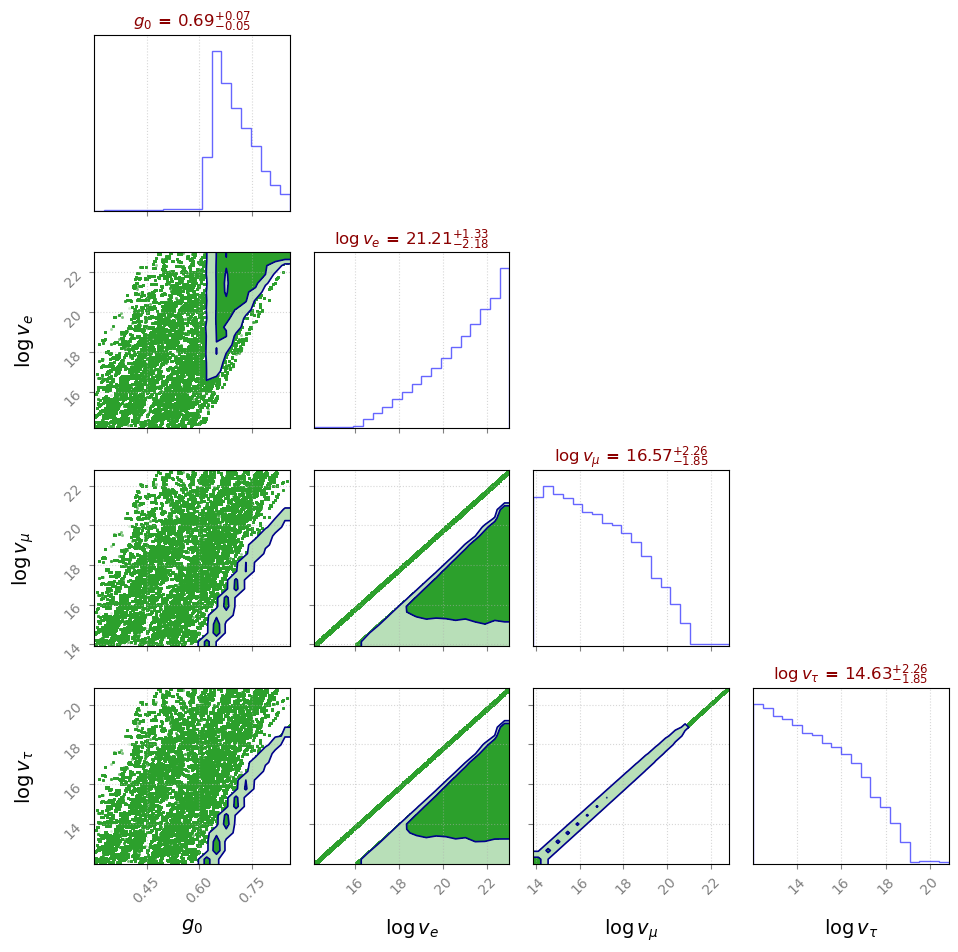

In [15]:
ndim = 4
nwalkers = 20
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = 0.7 + 0.01*np.random.randn(nwalkers)
p0[:,1] = 20 + np.random.randn(nwalkers)
p0[:,2] = 16 + np.random.randn(nwalkers)
p0[:,3] = 14 + np.random.randn(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=moves)
sampler.run_mcmc(p0, 10000, progress=True)
run = 10000
target = 1.05
while True:
    sampler.run_mcmc(None, 10000, progress=True)
    run += 10000
    samples = sampler.get_chain()
    Rhat = gelman_rubin(samples)
    print("R = {}, {}, {}, {} after {} runs".format(*Rhat, run))
    if np.all(Rhat < target):
        break

print(samples)

af = sampler.acceptance_fraction  # shape (nwalkers,)
print("Mean acceptance:", af.mean())

try:
    tau = sampler.get_autocorr_time(tol=0)
    print("Autocorrelation times:", tau)
except Exception as e:
    print("Autocorr time 계산 실패:", e)

burnin = int(2 * tau.max())  # 예: 2×max autocorr time
samples = sampler.get_chain(discard=burnin, flat=True)  # shape (nwalkers*nsteps_discarded, ndim)

labels=[r"$g_0$",r"$\log{v_e}$",r"$\log{v_{\mu}}$",r'$\log{v_{\tau}}$']

# 2. corner 옵션으로 색상·글꼴·라인바꾸기
figure = corner.corner(
    samples,
    labels=labels,
    color="C2",                        # 컨투어·히스토그램 선 색
    hist_kwargs={
        "density": True,
        "color":  "blue",         # 히스토그램 바 색
        "alpha":  0.6
    },
    contour_kwargs={
        "colors":    ["darkblue"],     # 컨투어 라인 색
        "linewidths": 1.2
    },
    plot_datapoints=True,              # 산점도로도 보여주기
    plot_contours=True,                # 컨투어 레벨 표시
    fill_contours=True,                # 컨투어 내부 채우기
    levels=(0.68, 0.95),               # 1σ, 2σ 레벨
    show_titles=True,
    title_kwargs={
        "fontsize": 12,
        "fontweight": "bold",
        "color": "darkred"
    },
    label_kwargs={
        "fontsize": 14,
        "fontfamily": "serif"
    }
)

# 3. 축·폰트·백그라운드 추가 커스터마이징
for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=10, colors='gray')
    ax.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

In [16]:
samples.shape

(66141820, 4)